# Gene type prediction with Transformers

Data collected from [Kaggle](https://www.kaggle.com/datasets/harshvardhan21/dna-sequence-prediction?resource=download&select=validation.csv) referes to nuocletide sequences and gene type encoded within them.

In [1]:
import pandas as pd

In [3]:
from eda import SequenceEDA
from preprocess import SequencePreprocess, detokenize, kmers_to_sequence
from model import TransformerGenerator

In [4]:
#load the datasets
train_df = pd.read_csv('train.csv', encoding='ascii')
val_df = pd.read_csv('validation.csv', encoding='ascii')
test_df = pd.read_csv('test.csv', encoding='ascii')

#dump on screen the shapes of the datasets
print('Training data shape:', train_df.shape)
print('Validation data shape:', val_df.shape)
print('Test data shape:', test_df.shape)

Training data shape: (22593, 7)
Validation data shape: (4577, 7)
Test data shape: (8326, 7)


In [5]:
#dump first five raws on screen
train_df.head()

,Unnamed: 0,NCBIGeneID,Symbol,Description,GeneType,GeneGroupMethod,NucleotideSequence
0,0,106481178,RNU4-21P,"RNA, U4 small nuclear 21, pseudogene",PSEUDO,NCBI Ortholog,<AGCTTAGCACAGTGGCAGTATCATAGGCAGTGAGGTTTATCCGAG...
1,1,123477792,LOC123477792,Sharpr-MPRA regulatory region 12926,BIOLOGICAL_REGION,NCBI Ortholog,<CTGGAGCGGCCACGATGTGAACTGTCACCGGCCACTGCTGCTCCG...
2,2,113174975,LOC113174975,Sharpr-MPRA regulatory region 7591,BIOLOGICAL_REGION,NCBI Ortholog,<TTCCCAATTTTTCCTCTGCTTTTTAATTTTCTAGTTTCCTTTTTC...
3,3,116216107,LOC116216107,CRISPRi-validated cis-regulatory element chr10...,BIOLOGICAL_REGION,NCBI Ortholog,<CGCCCAGGCTGGAGTGCAGTGGCGCCATCTCGGCTCACTGCAGGC...
4,4,28502,IGHD2-21,immunoglobulin heavy diversity 2-21,OTHER,NCBI Ortholog,<AGCATATTGTGGTGGTGACTGCTATTCC>


In [6]:
#remove useless columns
train_df = train_df.drop(['Unnamed: 0'], axis=1)
train_df = train_df.drop(['NCBIGeneID'], axis=1)
train_df = train_df.drop(['Symbol'], axis=1)
train_df = train_df.drop(['Description'], axis=1)
train_df = train_df.drop(['GeneGroupMethod'], axis=1)
val_df = val_df.drop(['Unnamed: 0'], axis=1)
val_df = val_df.drop(['NCBIGeneID'], axis=1)
val_df = val_df.drop(['Symbol'], axis=1)
val_df = val_df.drop(['Description'], axis=1)
val_df = val_df.drop(['GeneGroupMethod'], axis=1)
test_df = test_df.drop(['Unnamed: 0'], axis=1)
test_df = test_df.drop(['NCBIGeneID'], axis=1)
test_df = test_df.drop(['Symbol'], axis=1)
test_df = test_df.drop(['Description'], axis=1)
test_df = test_df.drop(['GeneGroupMethod'], axis=1)


#dump first five raws on screen
train_df.head()

,GeneType,NucleotideSequence
0,PSEUDO,<AGCTTAGCACAGTGGCAGTATCATAGGCAGTGAGGTTTATCCGAG...
1,BIOLOGICAL_REGION,<CTGGAGCGGCCACGATGTGAACTGTCACCGGCCACTGCTGCTCCG...
2,BIOLOGICAL_REGION,<TTCCCAATTTTTCCTCTGCTTTTTAATTTTCTAGTTTCCTTTTTC...
3,BIOLOGICAL_REGION,<CGCCCAGGCTGGAGTGCAGTGGCGCCATCTCGGCTCACTGCAGGC...
4,OTHER,<AGCATATTGTGGTGGTGACTGCTATTCC>


In [7]:
#remove < and >

train_df['NucleotideSequence'] = train_df['NucleotideSequence'].str.strip('<>')
val_df['NucleotideSequence'] = val_df['NucleotideSequence'].str.strip('<>')
test_df['NucleotideSequence'] = test_df['NucleotideSequence'].str.strip('<>')

## EDA

In [8]:
#define seq eda object
seq_eda = SequenceEDA(train_df, 'NucleotideSequence', 'GeneType')

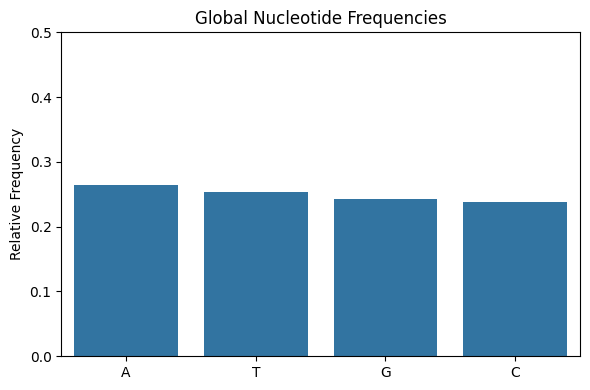

In [9]:
seq_eda.plot_nucleotide_frequencies()

The overall distribution of nucleotide frequencies appears relatively flat, with no individual nucleotide showing a dominant prevalence across the dataset. This uniformity suggests an absence of strong compositional biases within the sequences and provides limited biological insight into the underlying structure or function of the nucleotide regions. In particular, the lack of distinctive patterns or enrichment in specific bases implies that the sequences, when considered globally, may not reflect highly specialized motifs or conserved regions typically associated with particular biological roles.

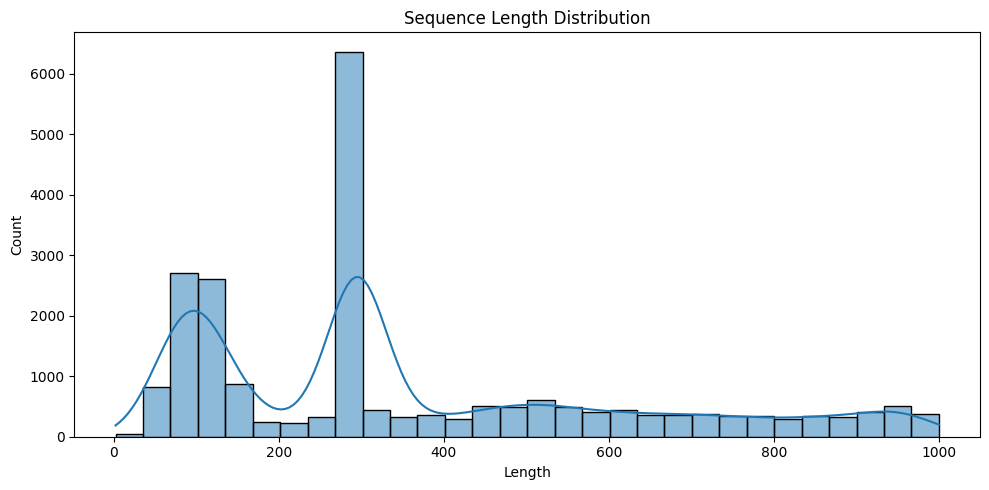

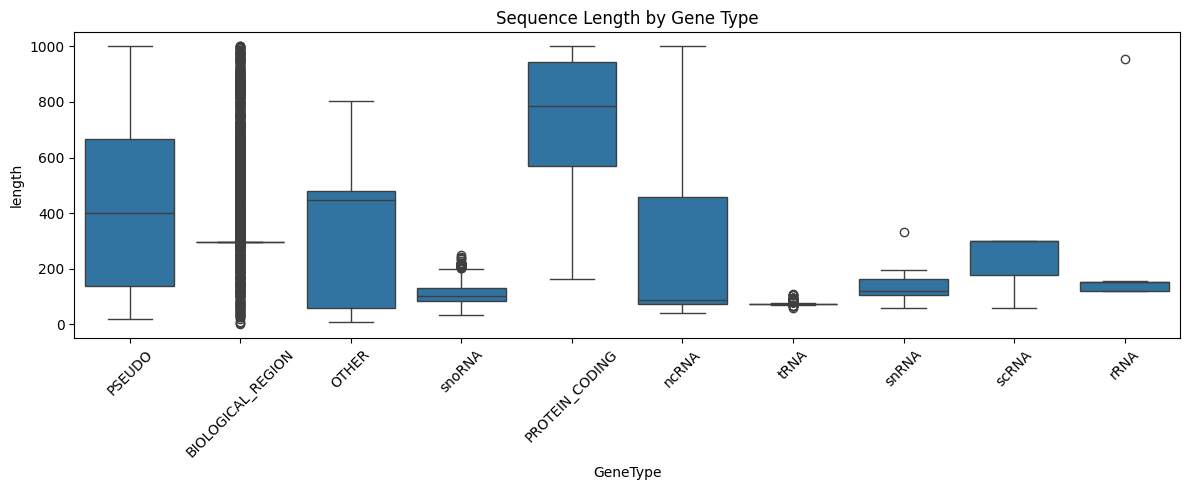

In [10]:
seq_eda.plot_sequence_length_distribution()

The distribution of nucleotide sequence lengths is heterogeneous, with a prominent peak around 284 nucleotides. Most gene types exhibit relatively well-defined and consistent sequence lengths, suggesting a degree of structural uniformity within those categories. However, the gene type labeled as biological region shows considerable variability, characterized by a wide range of lengths and a significant number of outliers. This indicates that biological region may encompass a more diverse set of genomic elements, possibly including regulatory regions, enhancers, or non-coding sequences with less constrained structural requirements.

## Prediction

In [11]:
#build object for preprocessing
train_prepro = SequencePreprocess(train_df)
valid_prepro = SequencePreprocess(val_df)
test_prepro = SequencePreprocess(test_df)

### Tokenization

In [12]:
#tokenize the sequences with k-mers
train_prepro.tokenize('NucleotideSequence')
valid_prepro.tokenize('NucleotideSequence')
test_prepro.tokenize('NucleotideSequence')

#print one sample on screen
print(train_prepro.tokens[0])

['AGCTTA', 'GCTTAG', 'CTTAGC', 'TTAGCA', 'TAGCAC', 'AGCACA', 'GCACAG', 'CACAGT', 'ACAGTG', 'CAGTGG', 'AGTGGC', 'GTGGCA', 'TGGCAG', 'GGCAGT', 'GCAGTA', 'CAGTAT', 'AGTATC', 'GTATCA', 'TATCAT', 'ATCATA', 'TCATAG', 'CATAGG', 'ATAGGC', 'TAGGCA', 'AGGCAG', 'GGCAGT', 'GCAGTG', 'CAGTGA', 'AGTGAG', 'GTGAGG', 'TGAGGT', 'GAGGTT', 'AGGTTT', 'GGTTTA', 'GTTTAT', 'TTTATC', 'TTATCC', 'TATCCG', 'ATCCGA', 'TCCGAG', 'CCGAGG', 'CGAGGC', 'GAGGCG', 'AGGCGT', 'GGCGTG', 'GCGTGA', 'CGTGAT', 'GTGATT', 'TGATTA', 'GATTAT', 'ATTATT', 'TTATTG', 'TATTGC', 'ATTGCC', 'TTGCCA', 'TGCCAA', 'GCCAAT', 'CCAATT', 'CAATTG', 'AATTGA', 'ATTGAA', 'TTGAAA', 'TGAAAA', 'GAAAAC', 'AAAACT', 'AAACTT', 'AACTTT', 'ACTTTT', 'CTTTTC', 'TTTTCT', 'TTTCTC', 'TTCTCG', 'TCTCGA', 'CTCGAT', 'TCGATA', 'CGATAC', 'GATACC', 'ATACCC', 'TACCCT', 'ACCCTT', 'CCCTTC', 'CCTTCT', 'CTTCTG', 'TTCTGT', 'TCTGTG', 'CTGTGA', 'TGTGAT', 'GTGATG', 'TGATGA', 'GATGAC', 'ATGACT', 'TGACTT', 'GACTTG', 'ACTTGC', 'CTTGCA', 'TTGCAA', 'TGCAAT', 'GCAATG', 'CAATGT', 'AATGTA',

### Encoding

In [13]:
#encoding the sequences
train_prepro.encode()
valid_prepro.encode()
test_prepro.encode()

#print one sample on screen
print(train_prepro.encoding[0])

[637, 2547, 1994, 3877, 3218, 581, 2323, 1100, 303, 1211, 746, 2981, 3731, 2636, 2349, 1204, 718, 2869, 3284, 845, 3379, 1227, 810, 3237, 659, 2636, 2351, 1209, 739, 2955, 3628, 2224, 704, 2813, 3060, 4046, 3894, 3287, 857, 3427, 1419, 1578, 2215, 668, 2671, 2489, 1764, 2960, 3645, 2292, 976, 3903, 3322, 998, 3989, 3665, 2372, 1296, 1087, 249, 993, 3969, 3585, 2050, 8, 32, 128, 512, 2046, 4088, 4062, 3959, 3545, 1892, 3469, 1586, 2246, 790, 3160, 352, 1406, 1528, 2015, 3964, 3567, 1977, 3812, 2959, 3641, 2274, 904, 3616, 2175, 506, 2021, 3985, 3652, 2319, 1084, 237, 947, 3788, 2862, 3253, 723, 2890, 3365, 1172, 592, 2367, 1275, 1002, 4005, 3729, 2627, 2315, 1068, 176, 704, 2816, 3072]


### Padding

In [14]:
#maximum length of dna sequence
max_len = max(len(sublist) for sublist in train_prepro.tokens)

train_prepro.pad_sequences(max_len)
valid_prepro.pad_sequences(max_len)
test_prepro.pad_sequences(max_len)

#print one sample on screen
print(train_prepro.padded[0])
print('Max sequence length:', max_len)

[ 637 2547 1994 3877 3218  581 2323 1100  303 1211  746 2981 3731 2636
 2349 1204  718 2869 3284  845 3379 1227  810 3237  659 2636 2351 1209
  739 2955 3628 2224  704 2813 3060 4046 3894 3287  857 3427 1419 1578
 2215  668 2671 2489 1764 2960 3645 2292  976 3903 3322  998 3989 3665
 2372 1296 1087  249  993 3969 3585 2050    8   32  128  512 2046 4088
 4062 3959 3545 1892 3469 1586 2246  790 3160  352 1406 1528 2015 3964
 3567 1977 3812 2959 3641 2274  904 3616 2175  506 2021 3985 3652 2319
 1084  237  947 3788 2862 3253  723 2890 3365 1172  592 2367 1275 1002
 4005 3729 2627 2315 1068  176  704 2816 3072    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

### Create y

In [15]:
y_train = train_prepro.create_y()
y_val = valid_prepro.create_y()
y_test = test_prepro.create_y()

### Get training, validation and test set

In [16]:
X_train = train_prepro.padded
X_val = valid_prepro.padded
X_test = test_prepro.padded
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

X_train shape: (22593, 995)
X_val shape: (4577, 995)
X_test shape: (8326, 995)


### Transformer model

In [17]:
transformer = TransformerGenerator(
    vocab_size=4097,  #k-mer 6 + 1 for padding
    max_len=max_len)

transformer.build(num_layers=1)
transformer.compile()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 995)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 995)       │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 995, 128)  │    524,416 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1, 1, 995) │          0 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 995, 128)  │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1, 995,    │          0 │ lambda_1[0][0]    │
│                     │ 995)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 995, 128)  │    527,488 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0],        │
│                     │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 995, 128)  │          0 │ add[0][0],        │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 995, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 995, 512)  │     66,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 995, 128)  │     65,664 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 995, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 995, 128)  │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 995, 4097) │    528,513 │ layer_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,712,641 (6.53 MB)

 Trainable params: 1,712,641 (6.53 MB)

 Non-trainable params: 0 (0.00 B)

### Fit model

In [18]:
transformer.fit(X_train,y_train,X_val,y_val)

Epoch 1/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 97s 85ms/step - loss: 3.0187 - masked_accuracy: 0.3003 - val_loss: 1.3427 - val_masked_accuracy: 0.3414 - learning_rate: 0.0010
Epoch 2/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - loss: 1.3343 - masked_accuracy: 0.3497 - val_loss: 1.2246 - val_masked_accuracy: 0.4464 - learning_rate: 0.0010
Epoch 3/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - loss: 1.1352 - masked_accuracy: 0.4987 - val_loss: 0.7546 - val_masked_accuracy: 0.7304 - learning_rate: 0.0010
Epoch 4/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - loss: 0.5449 - masked_accuracy: 0.7987 - val_loss: 0.2736 - val_masked_accuracy: 0.8931 - learning_rate: 0.0010
Epoch 5/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - loss: 0.2859 - masked_accuracy: 0.8898 - val_loss: 0.2246 - val_masked_accuracy: 0.9018 - learning_rate: 0.0010
Epoch 6/100
707/707 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - loss: 0.2406 - masked_accuracy: 0.8978 - val_loss: 0.2083 - val_masked_accuracy: 0.9040 - learning

### Evaluate

In [19]:
_, train_acc = transformer.model.evaluate(X_train, y_train, batch_size=32)
print(f'Train accuracy: {train_acc:.4f}')
_, test_acc = transformer.model.evaluate(X_test, y_test, batch_size=32)
print(f'Test accuracy: {test_acc:.4f}')

707/707 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0347 - masked_accuracy: 0.9867
Train accuracy: 0.9868
261/261 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 0.0487 - masked_accuracy: 0.9818
Test accuracy: 0.9836


The model achieves a training and test accuracy close to 99%, indicating that it has learned to predict the next token in DNA sequences with high reliability.

This level of performance suggests that the model has effectively captured the statistical patterns and dependencies present in the data, such as short-range correlations, recurring motifs, or sequence regularities.

The near-identical accuracy on both training and test sets is a strong indication of the model's ability to generalize, rather than memorizing specific sequences. It also confirms that the architecture and training strategy are well-suited to the task.

In [20]:
test_perplexity = transformer.compute_perplexity(X_test, y_test, batch_size=16)
print(f'Test perplexity: {test_perplexity:.2f}')

Test perplexity: 1.05


In language modeling, perplexity measures the average branching factor: a perplexity close to 1 suggests that the model assigns very high probability to the correct next token in the sequence. This means that the model has a near-deterministic understanding of the training distribution, which is a strong indicator of convergence and overfitting is unlikely when such low perplexity is also reflected on the validation or test set.

The model achieved a test set perplexity of 1.05, indicating that it is highly confident in its predictions and has effectively learned the statistical structure of the nucleotide sequences.

### Examples of generation

In [22]:
#generate samples
tokens = transformer.generate_samples(seed_seq=[100], num_samples=3, gen_len=50, temperature=1)

#for each generated token sequence
for i, token_seq in enumerate(tokens):
    #detokenize the sequence
    seq = detokenize(token_seq, k=6)
    #get the dna string
    dna_string = kmers_to_sequence(seq)
    #calculate gc content
    gc_count = dna_string.count('G') + dna_string.count('C')
    #calculate gc percent
    gc_percent = (gc_count / len(dna_string)) * 100
    #print the results
    print(f'Sample {i+1}: {dna_string}')
    print(f'Sequence length: {len(dna_string)}, GC count: {gc_count}')
    print(f'GC content: {gc_percent:.2f}%\n')


Sample 1: AACGATTACTTTGTCTCTCTTTTCCTCTTTTCACCCTTTCCTCCCCATTCTGTAA
Sequence length: 55, GC count: 22
GC content: 40.00%

Sample 2: AACGATTTTATCCTCCCCTCCTGCAATTACTCTCAGCGCTACTTCTACCCCCTTC
Sequence length: 55, GC count: 27
GC content: 49.09%

Sample 3: AACGATTCTCCTTTACCTTTCCTTAATCCCCCCCGAATTCCTTTATCTTCCTTTT
Sequence length: 55, GC count: 22
GC content: 40.00%



The generated DNA sequences are biologically plausible, with lengths consistent with the training dataset (55 nucleotides) and GC content ranging from 40% to 49%. All four nucleotides (A, T, G, C) are represented, and no impossible patterns are observed. These characteristics indicate that the model successfully captures the overall nucleotide distribution and sequence structure present in the training data.